In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
%matplotlib inline

In [3]:
df_train = pd.read_csv("../data/train_new.csv")
print('Number of train records: {}'.format(len(df_train)))
df_train.head()

Number of train records: 60000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.038835,0,0,0,0,1,2461.419769,2334.161163,2,67.0,...,1,0,0,0,0,0,0,0,0,1
1,0.504854,0,0,0,1,0,2371.483467,2341.480947,2,92.0,...,0,1,0,0,0,0,1,0,0,0
2,0.529126,0,0,0,1,1,2465.059892,2429.073831,7,67.0,...,1,0,0,0,0,1,0,0,0,0
3,0.033981,0,0,1,0,0,2419.540115,2635.040637,9,149.0,...,0,0,1,0,0,0,1,0,0,0
4,0.533981,0,0,1,0,1,2479.255239,2173.943626,7,68.0,...,1,0,0,0,0,1,0,0,0,0


In [4]:
df_test = pd.read_csv("../data/test_new.csv")
print('Number of test records: {}'.format(len(df_test)))
df_test.head()

Number of test records: 30000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.970874,1,0,1,1,1,2624.520690,2379.499974,7,121.0,...,0,0,0,1,0,0,0,0,1,0
1,0.524272,0,1,1,1,0,2524.058532,2615.882473,6,100.0,...,0,1,0,0,0,0,0,1,0,0
2,1.000000,0,1,1,0,0,2696.577167,2567.505982,2,91.0,...,0,1,0,0,0,0,0,0,0,1
3,0.033981,0,0,0,0,1,2515.834726,2821.948226,6,74.0,...,1,0,0,0,0,0,0,0,0,1
4,0.495146,0,0,0,0,1,2609.989756,2282.274343,7,121.0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# print(df_train.columns)
cols = ['rent_approval_date', 
        'town_0', 'town_1', 'town_2', 'town_3', 'town_4', #for binary encoding
#         'town', #for target encoding 
       'flat_model', 'floor_area_sqm', 'lease_commence_date',
       'avg_stock_price', 'num_shopping_malls', 'min_distance',
       'avg_coe_price', 'num_primary_schools', 'min_distance_planned',
       'flat_type_3-room', 'flat_type_4-room', 'flat_type_executive', 'flat_type_5-room', 'flat_type_2-room',
       'central region', 'east region', 'north region', 'north-east region', 'west region',
       'subzone', 'latitude', 'longitude'] #removed: 'furnished', 'elevation', 'planning_area', 'street_name', 'block'
"""
TODO:
1. submit output with subzone + lat/lon, SK learning rate 0.13, l2 2.9 
    -- SK 481.33169, CAT 482.53131(although lower MAE), LGB 484.328856
2. submit output with town target encoding instead of binary. SK lr 0.15, l2 2.9 
    -- SK 481.96167 --> choose binary encoding
"""

y_train = df_train['monthly_rent'].values
X_train = df_train[cols].values

X_test = df_test[cols].values

# Gradient Boosting with SKLearn

### Use HistGradientBoostingRegressor since it's much faster for large dataset

MAE: -365.926 (4.729)
30000
[3227, 2737, 3584, 1970, 2695]


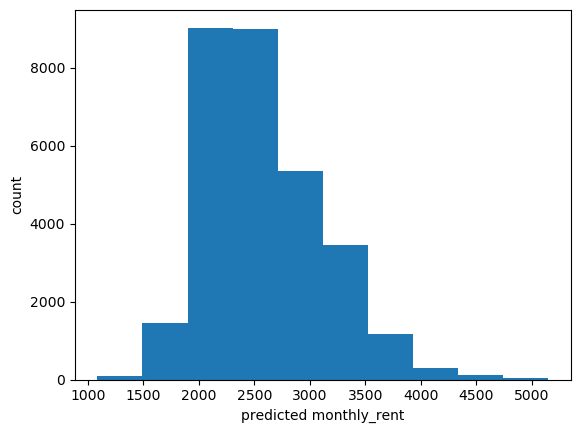

CPU times: user 2.46 s, sys: 141 ms, total: 2.6 s
Wall time: 4.92 s


In [6]:
%%time
categorical_features = []

model = HistGradientBoostingRegressor( loss='gamma',
                                        learning_rate=0.13, 
                                        max_depth=None,
                                        max_bins=255,
                                        categorical_features=categorical_features,
                                        random_state=237,
                                        l2_regularization=2.9) 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

# Gradient Boosting with XGBoost

In [7]:
%%time

model = XGBRegressor(objective ='reg:squarederror', alpha = 14)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

MAE: -368.819 (4.944)
CPU times: user 74.8 ms, sys: 11.8 ms, total: 86.6 ms
Wall time: 24.1 s


# Gradient Boosting with CatBoost

In [8]:
%%time
model = CatBoostRegressor(verbose=0, n_estimators=255)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

MAE: -365.753 (4.837)
CPU times: user 48.1 ms, sys: 12.2 ms, total: 60.4 ms
Wall time: 38.1 s


# Gradient Boosting with LightGBM

In [9]:
%%time
params = {
    "objective": "regression",
    "metric": "mse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
}

train_data = lgb.Dataset(X_train, label=y_train)
num_round = 1000
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=num_round,
    nfold=10,
    stratified=False,
)

best_round = len(cv_results["valid l2-mean"])
model = lgb.train(params, train_data, num_boost_round=best_round)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data p

In [10]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.head()

,Predicted
0,3227.0
1,2737.0
2,3584.0
3,1970.0
4,2695.0


In [11]:
df.to_csv("../data/gb_output.csv", index_label='Id')